In [1]:
import os
import keras
import tensorflow as tf
import numpy as np
import copy

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [3]:
import gait
from PIL import Image
from tensorflow.keras.utils import plot_model
from train import CVAE_FULL
from tqdm import tqdm
import cv2
from train_birnn import model_BiRNN, ImageNoise
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import gc
import pickle

In [4]:
EXP_NO = '044'
ANGLE_NO = '090'
gait_key_poses = 16
image_vec_shape = 12
conditional_vec_shape = 4
full_vec_shape = image_vec_shape+conditional_vec_shape
labels = ['nm-01', 'nm-02', 'nm-03', 'nm-04', 'nm-05', 'nm-06']

In [5]:
from train import CVAE_FULL

CVAE_FULL.load_weights('weights/CVAE_FULL.h5')

encoder = keras.models.Model(CVAE_FULL.input, CVAE_FULL.get_layer("concat_zcond").output)
encoded_vec = gait.encode_data(encoder,label_angle='090',override=True)
key_pose_info = gait.fetch_labels(save=False, override=True)

100%|██████████| 124/124 [00:15<00:00,  8.04it/s]


In [6]:
model_BiRNN.load_weights('weights/BiRNN.h5')

In [7]:
labels = ['nm-01', 'nm-02', 'nm-03', 'nm-04', 'nm-05', 'nm-06']
enc_inp = [None for _ in labels]
names = [None for _ in labels]
z = [None for _ in labels]
for i, label in enumerate(labels):
    enc_inp[i] = []
    names[i] = []
    z[i] = []
    for exp in os.listdir('/'.join([
                                os.getcwd(),
                                'GaitDatasetB-silh'
                                ])):
        name_sub = []
        z_sub = []
        files = sorted(os.listdir(
                    '/'.join([
                            os.getcwd(),
                            'GaitDatasetB-silh',
                            exp,
                            label,
                            ANGLE_NO
                            ])
                        )
                    )
        if len(files) < 10:
            continue
            
        for file in files:
            
            if file[-3:]!='png':
                continue
            
            
        
            name_sub.append(
                '/'.join([
                     os.getcwd(),
                     'GaitDatasetB-silh',
                     exp,
                     label,
                     ANGLE_NO,
                     file
                    ])
                )
            z_sub.append(key_pose_info[name_sub[-1]])
            
        names[i].append(name_sub)
        z[i].append(z_sub)
        enc_inp[i].append(encoded_vec[
                       '/'.join([
                             os.getcwd(),
                             'GaitDatasetB-silh',
                             exp,
                             label,
                             ANGLE_NO
                            ])
                        ])
        

In [8]:
def fetch_PEI(enc_vec, z, labels):
    PEI_Vecs = [None for _ in labels]
    for i, label in enumerate(labels):
        PEI_Vecs[i] = []
        for j, key_poses in enumerate(z[i]):
            key_poses = np.array(key_poses)
            PEI_vec = [None for _ in range(16)]
            for k in range(16):
                PEI_vec[k] = np.nan_to_num(enc_vec[i][j][key_poses==k].mean(axis=0))
            PEI_Vecs[i].append(np.array(PEI_vec))
        PEI_Vecs[i] = np.array(PEI_Vecs[i])
    y = []
    for i in range(len(labels)):
        y.append(i*np.ones(PEI_Vecs[i].shape[0]))
    y = np.concatenate(y,axis=0)
    PEI_Vecs = np.concatenate(PEI_Vecs, axis=0)
    
    return PEI_Vecs, y

In [9]:
def occlude(enc_vec, labels, occluRatio=0.3):
    enc_vecs = copy.deepcopy(enc_vec)
    for i, label in enumerate(labels):
        for j in range(len(enc_vecs[i])):
            mask = np.random.random((len(enc_vecs[i][j]),1)) > occluRatio
            enc_vecs[i][j] = mask*enc_vecs[i][j]
    return enc_vecs

In [10]:
def filter_enc(enc_vec, model_birnn, labels):
    batch_enc = []
    for i, label in enumerate(labels):
        for j in range(len(enc_vec[i])):
            for k in range(len(enc_vec[i][j])-6 + 1):
                batch_enc.append(enc_vec[i][j][k:k+6])
    batch_enc = np.array(batch_enc)

    batch_enc = model_birnn.predict( batch_enc )
    cnt = 0

    for i, label in enumerate(labels):
        for j in range(len(enc_vec[i])):
            for k in range(len(enc_vec[i][j])-6 + 1):
                enc_vec[i][j][k:k+6] = batch_enc[cnt]
                cnt+=1
    
    return enc_vec

In [11]:
PEI_Vecs, y = fetch_PEI(enc_inp, z, labels)

/home/hexplex0xff/GAN/gan/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice.
  if __name__ == '__main__':
/home/hexplex0xff/GAN/gan/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [12]:
enc_vec = occlude(enc_inp, labels, 0.0)
enc_vec = filter_enc(enc_vec, model_BiRNN, labels)
PEI_Vecs, y = fetch_PEI(enc_vec, z, labels)

/home/hexplex0xff/GAN/gan/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice.
  if __name__ == '__main__':


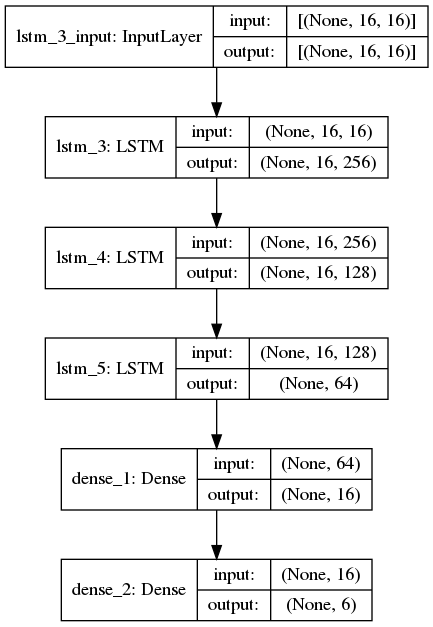

In [13]:
model_classifier = keras.models.Sequential()
model_classifier.add(keras.layers.LSTM( 256,
                                        activation='tanh',
                                        return_sequences = True,
                                        input_shape=(gait_key_poses, full_vec_shape)
                                    )
                        )
model_classifier.add(keras.layers.LSTM( 128,
                                        activation='tanh',
                                        return_sequences=True,
                        )
                    )
model_classifier.add(keras.layers.LSTM(64,
                                       activation='tanh'
                        )
                    )
model_classifier.add(keras.layers.Dense(16,
                                        activation='tanh'
                        )
                    )
model_classifier.add(keras.layers.Dense(len(labels),
                                       activation='softmax'
                        )
                    )
model_classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
plot_model(model_classifier, to_file='media/model_classifier_plot.png', show_shapes=True, show_layer_names=True)
im = Image.open('media/model_classifier_plot.png')
im

In [38]:
model_classifier.save('weights/random_classifier.h5')

In [39]:
dataset_size = [0.94, 0.9, 0.82,0.7, 0.5]
epoch_len = [20, 35, 50, 70, 100]
n_fold_val = [int(1/(1-ele)) for ele in dataset_size]
print(n_fold_val)

[16, 10, 5, 3, 2]


In [40]:
from sklearn.model_selection import StratifiedKFold

In [45]:
results = []

for i, (ds, nf) in enumerate(zip(dataset_size, n_fold_val)):
    res = []
    for ep in epoch_len:
        result = []
        skf = StratifiedKFold(n_splits=nf,shuffle=True)
        skf.get_n_splits(PEI_Vecs, y)

        for train_index, test_index in skf.split(PEI_Vecs, y):
            model_classifier.load_weights('weights/random_classifier.h5')
            model_classifier.fit(PEI_Vecs[train_index], y[train_index], epochs=ep, verbose=0)
            y_pred_inter = model_classifier.predict(PEI_Vecs[test_index])
            acc = (np.argmax(y_pred_inter, axis=-1) == y[test_index]).sum() / len(test_index)
            loss = (np.argmax(y_pred_inter, axis=-1) != y[test_index]).sum() / len(test_index)
            result.append([acc, loss, [ep,ds]])
        accuracy_over_k = sum([r[0] for r in result])/len(result)
        print("for",ep,"no. of epochs trained on",100*ds,"% data has",accuracy_over_k,"acc")
        res.append(result)
    results.append(res)
        #print(train_index, test_index)

SyntaxError: invalid syntax (<ipython-input-45-cdbbd6f252e8>, line 7)